# IEMOCAP model2

Introduction of labels weighting.

Played with a few parameters such as sample rate for our images and many more

In [11]:
#load the data
import csv
import numpy as np

labels1 = np.load('processing_dataset/labels.npy')
# Extract the onehot encoded labels

spectrograms = np.load("final_dataset/spectrograms.npy")
print("Spectrogramms load finished")

classes = ["Anger","Excited","Fear","Frustration","Happiness","Neutral","Sadness"]


Spectrogramms load finished


In [12]:
#transform the classes to digits (used for weight dictionary)
class_indices = dict((classe, index) for index, classe in enumerate(classes))
print(class_indices)

{'Anger': 0, 'Excited': 1, 'Fear': 2, 'Frustration': 3, 'Happiness': 4, 'Neutral': 5, 'Sadness': 6}


In [13]:
#transform labels to digit according to the class dict
digit_labels = [class_indices[label] for label in labels1]


[3, 3, 3, 3, 5, 3, 5, 3, 3, 3]


In [14]:
# Create a DataFrame with a single column containing the labels

import pandas as pd
df = pd.DataFrame(digit_labels, columns=['labels'])

In [15]:
# Use the get_dummies function to one-hot encode the labels
from sklearn.utils import class_weight

one_hot = pd.get_dummies(df['labels'])
print(one_hot)

#weights computation
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(df['labels']),
                                                  y=df['labels'])

class_weight_dict = dict(zip(np.unique(digit_labels), class_weights))


       0  1  2  3  4  5  6
0      0  0  0  0  0  1  0
1      0  0  0  0  0  1  0
2      0  0  0  0  0  1  0
3      0  0  0  0  0  1  0
4      0  0  0  0  0  1  0
...   .. .. .. .. .. .. ..
19924  0  1  0  0  0  0  0
19925  0  1  0  0  0  0  0
19926  0  1  0  0  0  0  0
19927  0  1  0  0  0  0  0
19928  0  1  0  0  0  0  0

[19929 rows x 7 columns]
[2.18663594 0.53818526 3.15282392 0.413748   2.47565217 2.33743842
 0.89387755]
{0: 2.186635944700461, 1: 0.5381852551984877, 2: 3.1528239202657806, 3: 0.41374800174393256, 4: 2.4756521739130433, 5: 2.3374384236453203, 6: 0.8938775510204081}


In [16]:
#Split data Train/validation
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split

# Convert the one-hot encoded DataFrame to a tensor
labels = torch.tensor(one_hot.values, dtype=torch.float32)

# split the data into training and validation sets
spectrograms = torch.tensor(spectrograms)

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(spectrograms, labels, test_size=0.25, random_state=42)

# normalize the spectrograms
train_spectrograms /= 255.0
val_spectrograms /= 255.0

print(val_spectrograms.shape)
train_spectrograms.shape[1:]

# convert the lists to TensorFlow tensors
train_spectrograms = tf.convert_to_tensor(train_spectrograms, dtype=tf.float32)
val_spectrograms = tf.convert_to_tensor(val_spectrograms, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
val_labels = tf.convert_to_tensor(val_labels, dtype=tf.int32)

# add a channel dimension to the spectrograms
train_spectrograms = tf.expand_dims(train_spectrograms, axis=-1)
val_spectrograms = tf.expand_dims(val_spectrograms, axis=-1)



torch.Size([4983, 128, 156])


In [17]:
#model creation

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_spectrograms.shape[1:],padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(classes), activation='softmax'))

model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 156, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 78, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 64, 78, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 39, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 79872)            

In [18]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(train_spectrograms, train_labels, batch_size=32, epochs=30, validation_data=(val_spectrograms, val_labels),class_weight=class_weight_dict)

Epoch 1/30
468/468 [==============================] - 201s 425ms/step - loss: 1.9466 - accuracy: 0.1868 - val_loss: 1.9057 - val_accuracy: 0.1642
Epoch 2/30
468/468 [==============================] - 195s 417ms/step - loss: 1.8875 - accuracy: 0.2085 - val_loss: 1.8703 - val_accuracy: 0.2171
Epoch 3/30
468/468 [==============================] - 192s 411ms/step - loss: 1.8524 - accuracy: 0.2070 - val_loss: 1.9043 - val_accuracy: 0.1523
Epoch 4/30
468/468 [==============================] - 193s 412ms/step - loss: 1.8111 - accuracy: 0.2251 - val_loss: 1.8376 - val_accuracy: 0.2081
Epoch 5/30
468/468 [==============================] - 191s 407ms/step - loss: 1.7480 - accuracy: 0.2391 - val_loss: 1.8316 - val_accuracy: 0.2238
Epoch 6/30
468/468 [==============================] - 190s 407ms/step - loss: 1.6506 - accuracy: 0.2707 - val_loss: 1.8965 - val_accuracy: 0.1595
Epoch 7/30
468/468 [==============================] - 192s 410ms/step - loss: 1.5440 - accuracy: 0.2991 - val_loss: 1.8447 -

156/156 [==============================] - 10s 63ms/step


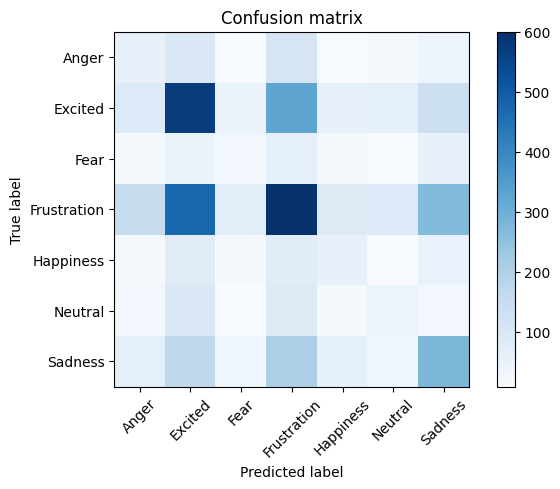

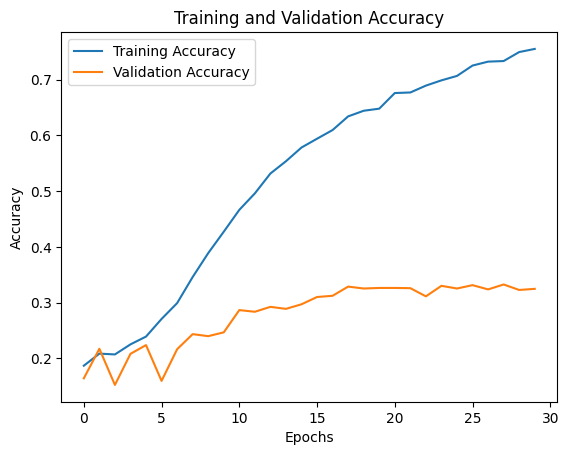

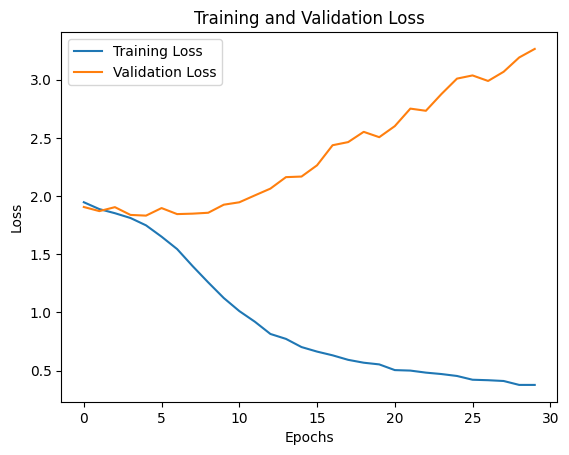

In [19]:
#results and analysis

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predicted labels
pred_labels = np.argmax(model.predict(val_spectrograms), axis=1)

# Convert the one-hot encoded labels to integer labels
val_labels_int = np.argmax(val_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(val_labels_int, pred_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Get the training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get the training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a line plot of the training and validation accuracy values
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Create a line plot of the training and validation loss values
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
